In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.model_selection import train_test_split

### Loading in Train dataset

In [4]:
train_dir = "IndustryBiscuit_Folders/train"

ok_dir = os.path.join(train_dir, "ok")
nok_dir = os.path.join(train_dir, "nok")

ok_images = [os.path.join(ok_dir, img) for img in os.listdir(ok_dir) if img.endswith(".jpg")]
nok_images = [os.path.join(nok_dir, img) for img in os.listdir(nok_dir) if img.endswith(".jpg")]

Total OK images in train: 1000
Total NOK images in train: 50


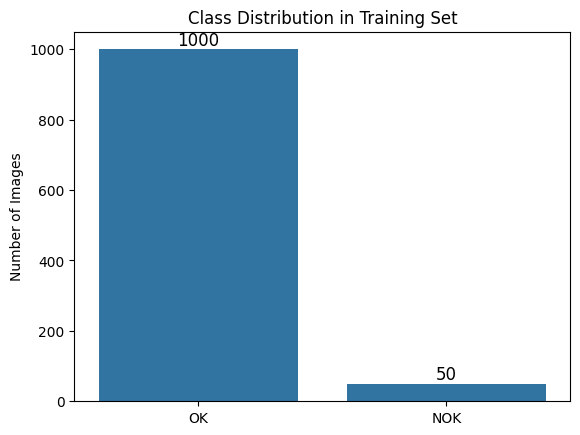

In [5]:
print(f"Total OK images in train: {len(ok_images)}")
print(f"Total NOK images in train: {len(nok_images)}")
sns.barplot(x=["OK", "NOK"], y=[len(ok_images), len(nok_images)])
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
for i, count in enumerate([len(ok_images), len(nok_images)]):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

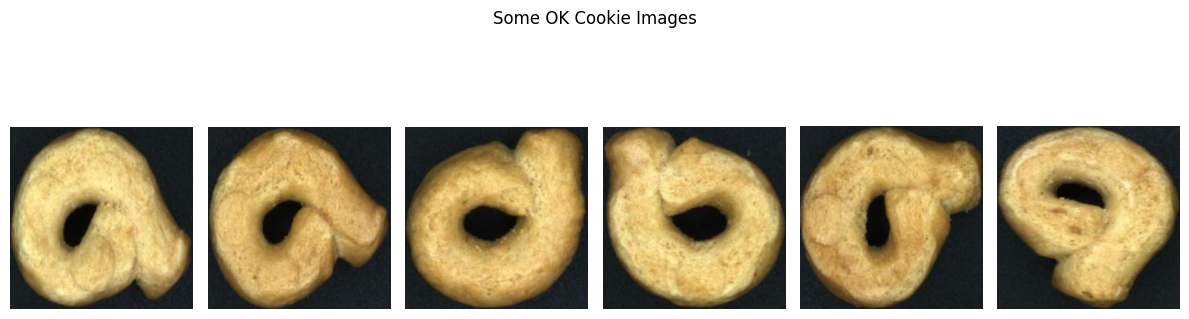

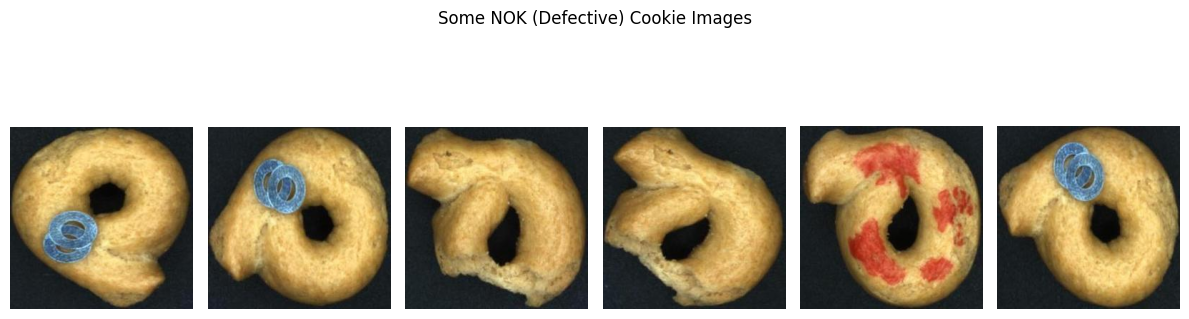

In [6]:
import random

def show_images(image_paths, title, n=6):
    # Randomly select n images from the image_paths
    selected_images = random.sample(image_paths, min(n, len(image_paths)))
    plt.figure(figsize=(12, 4))
    for i, img_path in enumerate(selected_images):
        img = load_img(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage
show_images(ok_images, "Some OK Cookie Images")
show_images(nok_images, "Some NOK (Defective) Cookie Images")

### VAE

In [7]:
# Function to load and preprocess images (colored)
def load_images(image_paths, target_size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)  # Load as RGB (default)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_images(image_paths, target_size=(256, 256)):
    """
    Load and preprocess images from the given paths.

    Parameters:
    - image_paths: List of image file paths.
    - target_size: Tuple specifying the target size (height, width).

    Returns:
    - NumPy array of preprocessed images.
    """
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)  # Load image
        img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert to array
        if img_array.shape[-1] == 1:  # If grayscale, convert to RGB
            img_array = tf.image.grayscale_to_rgb(img_array)
        images.append(img_array)
    return np.array(images)

# Define directories for training and test data
train_base_dir = "IndustryBiscuit_Folders/train"
test_base_dir = "IndustryBiscuit_Folders/test"

# Load training images (only 'ok' images since VAE trains on good data only)
ok_train_dir = os.path.join(train_base_dir, "ok")
ok_train_images = [os.path.join(ok_train_dir, img) for img in os.listdir(ok_train_dir) if img.endswith(".jpg")]
if not ok_train_images:
    raise ValueError("No training images found in the 'ok' directory.")
X_train = load_images(ok_train_images)

# Split training data into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=40, shuffle=True) # 80% train, 20% validation

# Create y_val (all zeros since validation data is from 'ok' images)
y_val = np.zeros(len(X_val))

# Load test images (both 'ok' and 'nok')
ok_test_dir = os.path.join(test_base_dir, "ok")
nok_test_dir = os.path.join(test_base_dir, "nok")
ok_test_images = [os.path.join(ok_test_dir, img) for img in os.listdir(ok_test_dir) if img.endswith(".jpg")]
nok_test_images = [os.path.join(nok_test_dir, img) for img in os.listdir(nok_test_dir) if img.endswith(".jpg")]
if not ok_test_images or not nok_test_images:
    raise ValueError("No test images found in the 'ok' or 'nok' directories.")
X_test_ok = load_images(ok_test_images)
X_test_nok = load_images(nok_test_images)

# Combine test data (both ok and nok together) and create labels
X_test = np.concatenate([X_test_ok, X_test_nok], axis=0)
y_test = np.concatenate([np.zeros(len(X_test_ok)), np.ones(len(X_test_nok))], axis=0)  # 0 = ok, 1 = nok

# Ensure data is in the correct shape
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Print dataset lengths for verification
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

Length of X_train: 900
Length of X_val: 100
Length of X_test: 400
Length of y_test: 400


In [9]:
from tensorflow.keras import layers
import tensorflow as tf

# Define Sampling Layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
from tensorflow.keras import Model

# Define Encoder
latent_dim = 128
encoder_inputs = layers.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 16,777,344 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,903,616 (64.48 MB)

 Trainable params: 16,903,616 (64.48 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation=None)(latent_inputs)  # No activation here
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # (32, 32, 64)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # (64, 64, 32)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)  # (128, 128, 16)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)  # (256, 256, 3)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 256, 256, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,173,987 (8.29 MB)

 Trainable params: 2,173,987 (8.29 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf
from tensorflow.keras import Model

class VAE(Model):
    """
    Variational Autoencoder (VAE) model with custom training step.
    Includes KL divergence loss and reconstruction loss.
    """
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # Scaling factor for KL loss

    def call(self, inputs):
        """
        Forward pass: Encodes inputs to latent space and reconstructs them.
        """
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        """
        Custom training step for the VAE.
        Computes reconstruction loss and KL divergence loss.
        """
        if isinstance(data, tuple):
            data = data[0]

        # Ensure data has a channel dimension
        if len(data.shape) == 3:  # If shape is [batch_size, height, width]
            data = tf.expand_dims(data, axis=-1)  # Add channel dimension

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Ensure reconstruction has the same shape as data
            if len(reconstruction.shape) == 3:  # If channel dimension is missing
                reconstruction = tf.expand_dims(reconstruction, axis=-1)

            # Reconstruction loss (sum over height and width)
            reconstruction_loss = tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2]
            )
            reconstruction_loss = tf.reduce_mean(reconstruction_loss)  # Average over batch

            # KL Divergence Loss
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

            # Total Loss
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Return losses as metrics
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        """
        Custom test step for validation.
        Computes reconstruction loss and KL divergence loss on validation data.
        """
        if isinstance(data, tuple):
            data = data[0]

        # Ensure data has a channel dimension
        if len(data.shape) == 3:  # If shape is [batch_size, height, width]
            data = tf.expand_dims(data, axis=-1)  # Add channel dimension

        # Forward pass
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Ensure reconstruction has the same shape as data
        if len(reconstruction.shape) == 3:  # If channel dimension is missing
            reconstruction = tf.expand_dims(reconstruction, axis=-1)

        # Reconstruction loss (sum over height and width)
        reconstruction_loss = tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction), axis=[1, 2]
        )
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)  # Average over batch

        # KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # Total Loss
        total_loss = reconstruction_loss + self.beta * kl_loss

        # Return losses as metrics
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [13]:
# Train the VAE
vae = VAE(encoder, decoder, beta=0.3)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - kl_loss: 27.6699 - loss: 43768.5898 - reconstruction_loss: 43760.2891 - val_kl_loss: 4.7151 - val_loss: 41166.5781 - val_reconstruction_loss: 41165.1641
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - kl_loss: 3.7213 - loss: 40141.0000 - reconstruction_loss: 40139.8867 - val_kl_loss: 2.8486 - val_loss: 38769.1445 - val_reconstruction_loss: 38768.2891
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - kl_loss: 3.3180 - loss: 38026.3438 - reconstruction_loss: 38025.3477 - val_kl_loss: 3.5896 - val_loss: 36555.4023 - val_reconstruction_loss: 36554.3242
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 891ms/step - kl_loss: 3.8119 - loss: 35692.4609 - reconstruction_loss: 35691.3164 - val_kl_loss: 3.5666 - val_loss: 35061.8945 - val_reconstruction_loss: 35060.8242
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 882ms/step - kl_loss: 3.9594 - loss: 34536.2969 - reconstruction_loss: 34535.1094 - val_kl_loss: 4.2145 - val_loss: 34725.8750 - val_recon

In [21]:
# # Save the VAE model
# vae.save('vae_model1.keras')

# # Load the VAE model
# vae = tf.keras.models.load_model('vae_model1.keras', custom_objects={'VAE': VAE, 'Encoder': Encoder, 'Decoder': Decoder})

NameError: name 'Encoder' is not defined

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

# Step 1: Generate reconstructed data using the VAE
X_test_reconstructed = vae.predict(X_test)
X_val_reconstructed = vae.predict(X_val)

# Ensure input and output are float32 and in [0, 1] range
X_test = X_test.astype("float32")
X_test_reconstructed = X_test_reconstructed.astype("float32")
X_val = X_val.astype("float32")
X_val_reconstructed = X_val_reconstructed.astype("float32")

# Step 2: Compute reconstruction error using Binary Crossentropy
# Compute BCE per sample (mean over all pixels and channels)
reconstruction_error = np.mean(binary_crossentropy(X_test, X_test_reconstructed).numpy(), axis=(1, 2))
reconstruction_error_val = np.mean(binary_crossentropy(X_val, X_val_reconstructed).numpy(), axis=(1, 2))

# Step 3: Determine the best threshold using the validation set
precision, recall, thresholds = precision_recall_curve(y_val, reconstruction_error_val)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
best_threshold_idx = np.argmax(f1_scores)

# Ensure the best threshold index is valid
if best_threshold_idx < len(thresholds):
    best_threshold = thresholds[best_threshold_idx]
else:
    best_threshold = thresholds[-1]

# Step 4: Adjust the threshold manually if needed
manual_threshold = best_threshold + 0.043  # Change +0 to something else if tuning
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Manual Threshold (Adjusted): {manual_threshold:.4f}")

# Step 5: Predict anomalies on the test set
y_pred = (reconstruction_error > manual_threshold).astype(int)

# Step 6: Ensure y_test is a NumPy array and of integer type
y_test = np.array(y_test).astype(int)

# Step 7: Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 
Best Threshold: 0.4664
Manual Threshold (Adjusted): 0.5094
Accuracy: 0.84
Precision: 0.80
Recall: 0.92
F1-Score: 0.85


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


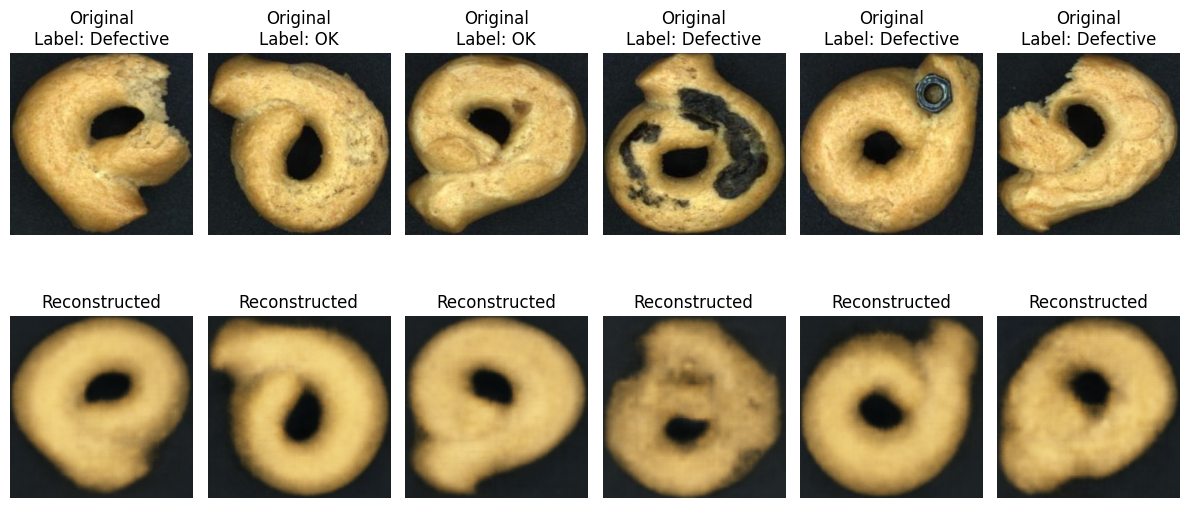

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstructions_with_labels(original, reconstructed, labels, n=6):
    """
    Visualize original vs reconstructed images side by side with ground truth labels.

    Parameters:
    - original: Original images (NumPy array).
    - reconstructed: Reconstructed images (NumPy array).
    - labels: Ground truth labels (1 for defective, 0 for non-defective).
    - n: Number of images to display.
    """
    # Randomly select n images
    indices = np.random.choice(len(original), n, replace=False)
    original_selected = original[indices]
    reconstructed_selected = reconstructed[indices]
    labels_selected = labels[indices]

    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Display original image
        plt.subplot(2, n, i + 1)
        plt.imshow(original_selected[i], cmap="gray")
        plt.title(f"Original\nLabel: {'Defective' if labels_selected[i] == 1 else 'OK'}")
        plt.axis("off")

        # Display reconstructed image
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_selected[i], cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
visualize_reconstructions_with_labels(X_test, X_test_reconstructed, y_test, n=6)

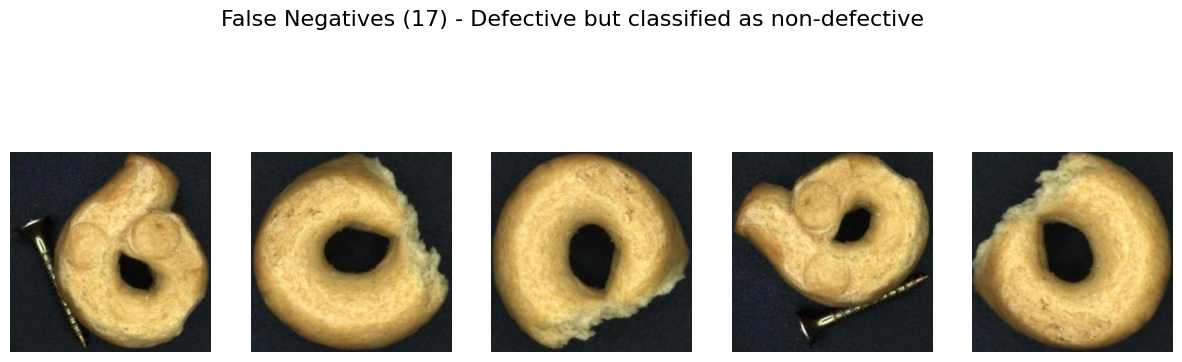

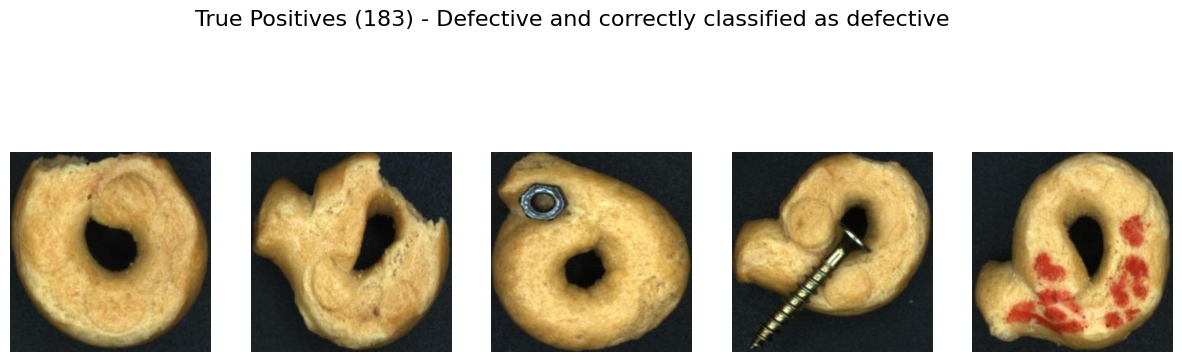

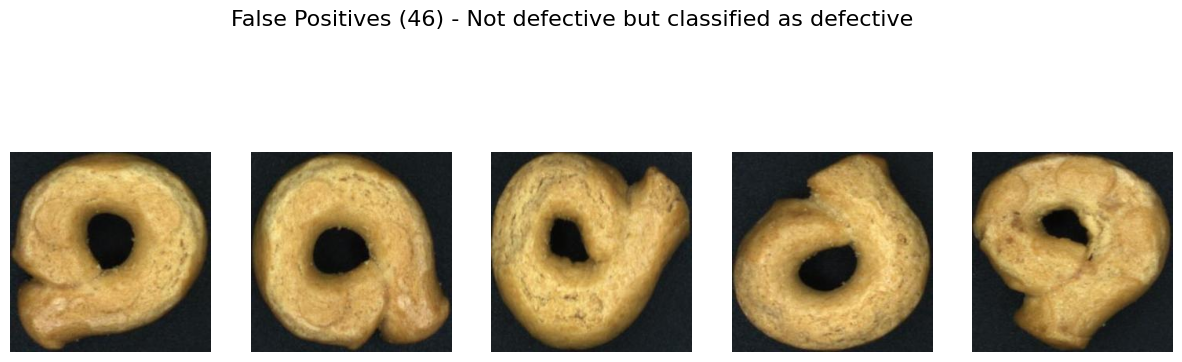

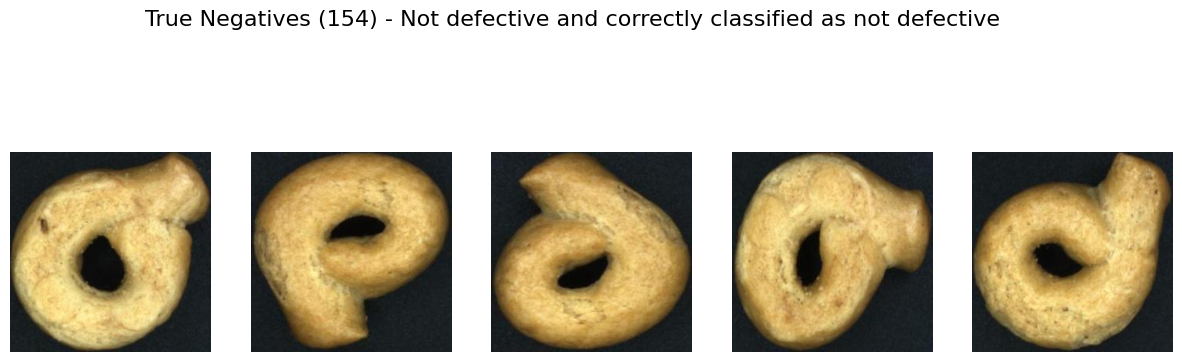

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(indices, title, X_test, max_images=5):
    if len(indices) == 0:
        print(f"No images to display for: {title}")
        return

    num_images = min(len(indices), max_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create a row of subplots
    fig.suptitle(title, fontsize=16)

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one image

    for i, idx in enumerate(indices[:num_images]):
        axes[i].imshow(X_test[idx])
        axes[i].axis('off')
    plt.show()

# False Negatives: Defective but classified as non-defective
false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]
plot_images(false_negatives, f"False Negatives ({len(false_negatives)}) - Defective but classified as non-defective", X_test)

# True Positives: Defective and correctly classified as defective
true_positives = np.where((y_test == 1) & (y_pred == 1))[0]
plot_images(true_positives, f"True Positives ({len(true_positives)}) - Defective and correctly classified as defective", X_test)

# False Positives: Not defective but classified as defective
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]
plot_images(false_positives, f"False Positives ({len(false_positives)}) - Not defective but classified as defective", X_test)

# True Negatives: Not defective and correctly classified as not defective
true_negatives = np.where((y_test == 0) & (y_pred == 0))[0]
plot_images(true_negatives, f"True Negatives ({len(true_negatives)}) - Not defective and correctly classified as not defective", X_test)

### Classification into the 3 defect categories

In [29]:
# Get only the NOK samples
X_nok = X_test[y_test == 1]

# Get latent vectors for NOK images
z_nok = vae.encoder(X_nok)[2].numpy()

In [30]:
from sklearn.cluster import KMeans

# Cluster into 3 groups for 3 defect types
kmeans = KMeans(n_clusters=3, random_state=40)
cluster_labels = kmeans.fit_predict(z_nok)  # Unsupervised cluster assignment

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


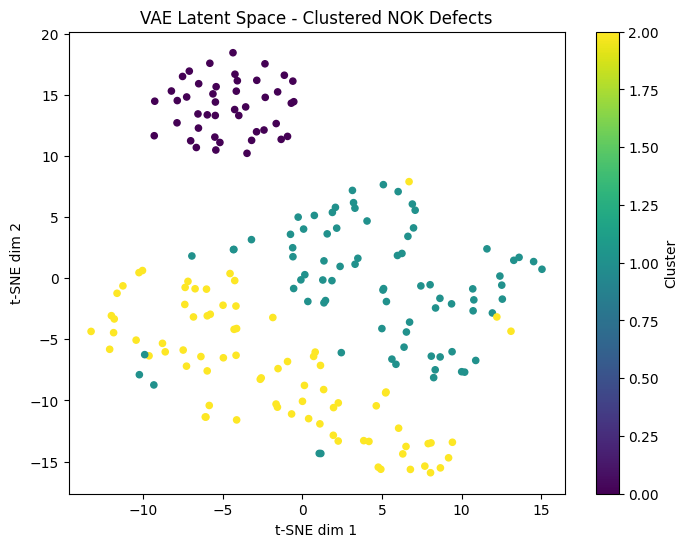

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z_2d = TSNE(n_components=2, random_state=42).fit_transform(z_nok)

plt.figure(figsize=(8,6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.title("VAE Latent Space - Clustered NOK Defects")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.colorbar(label='Cluster')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


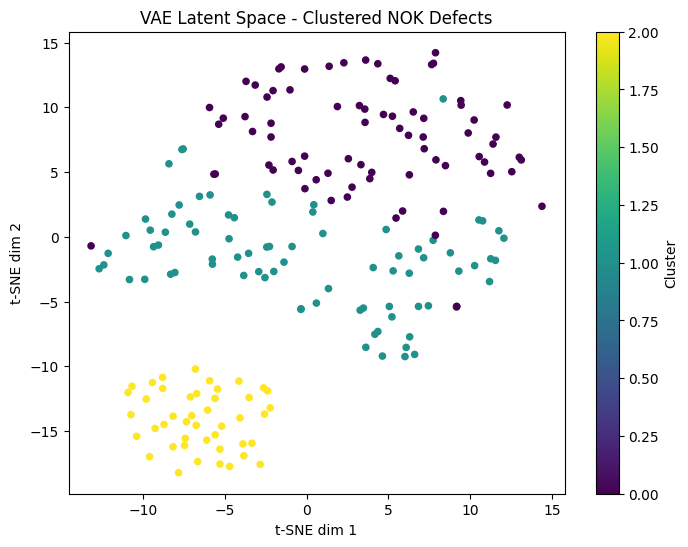

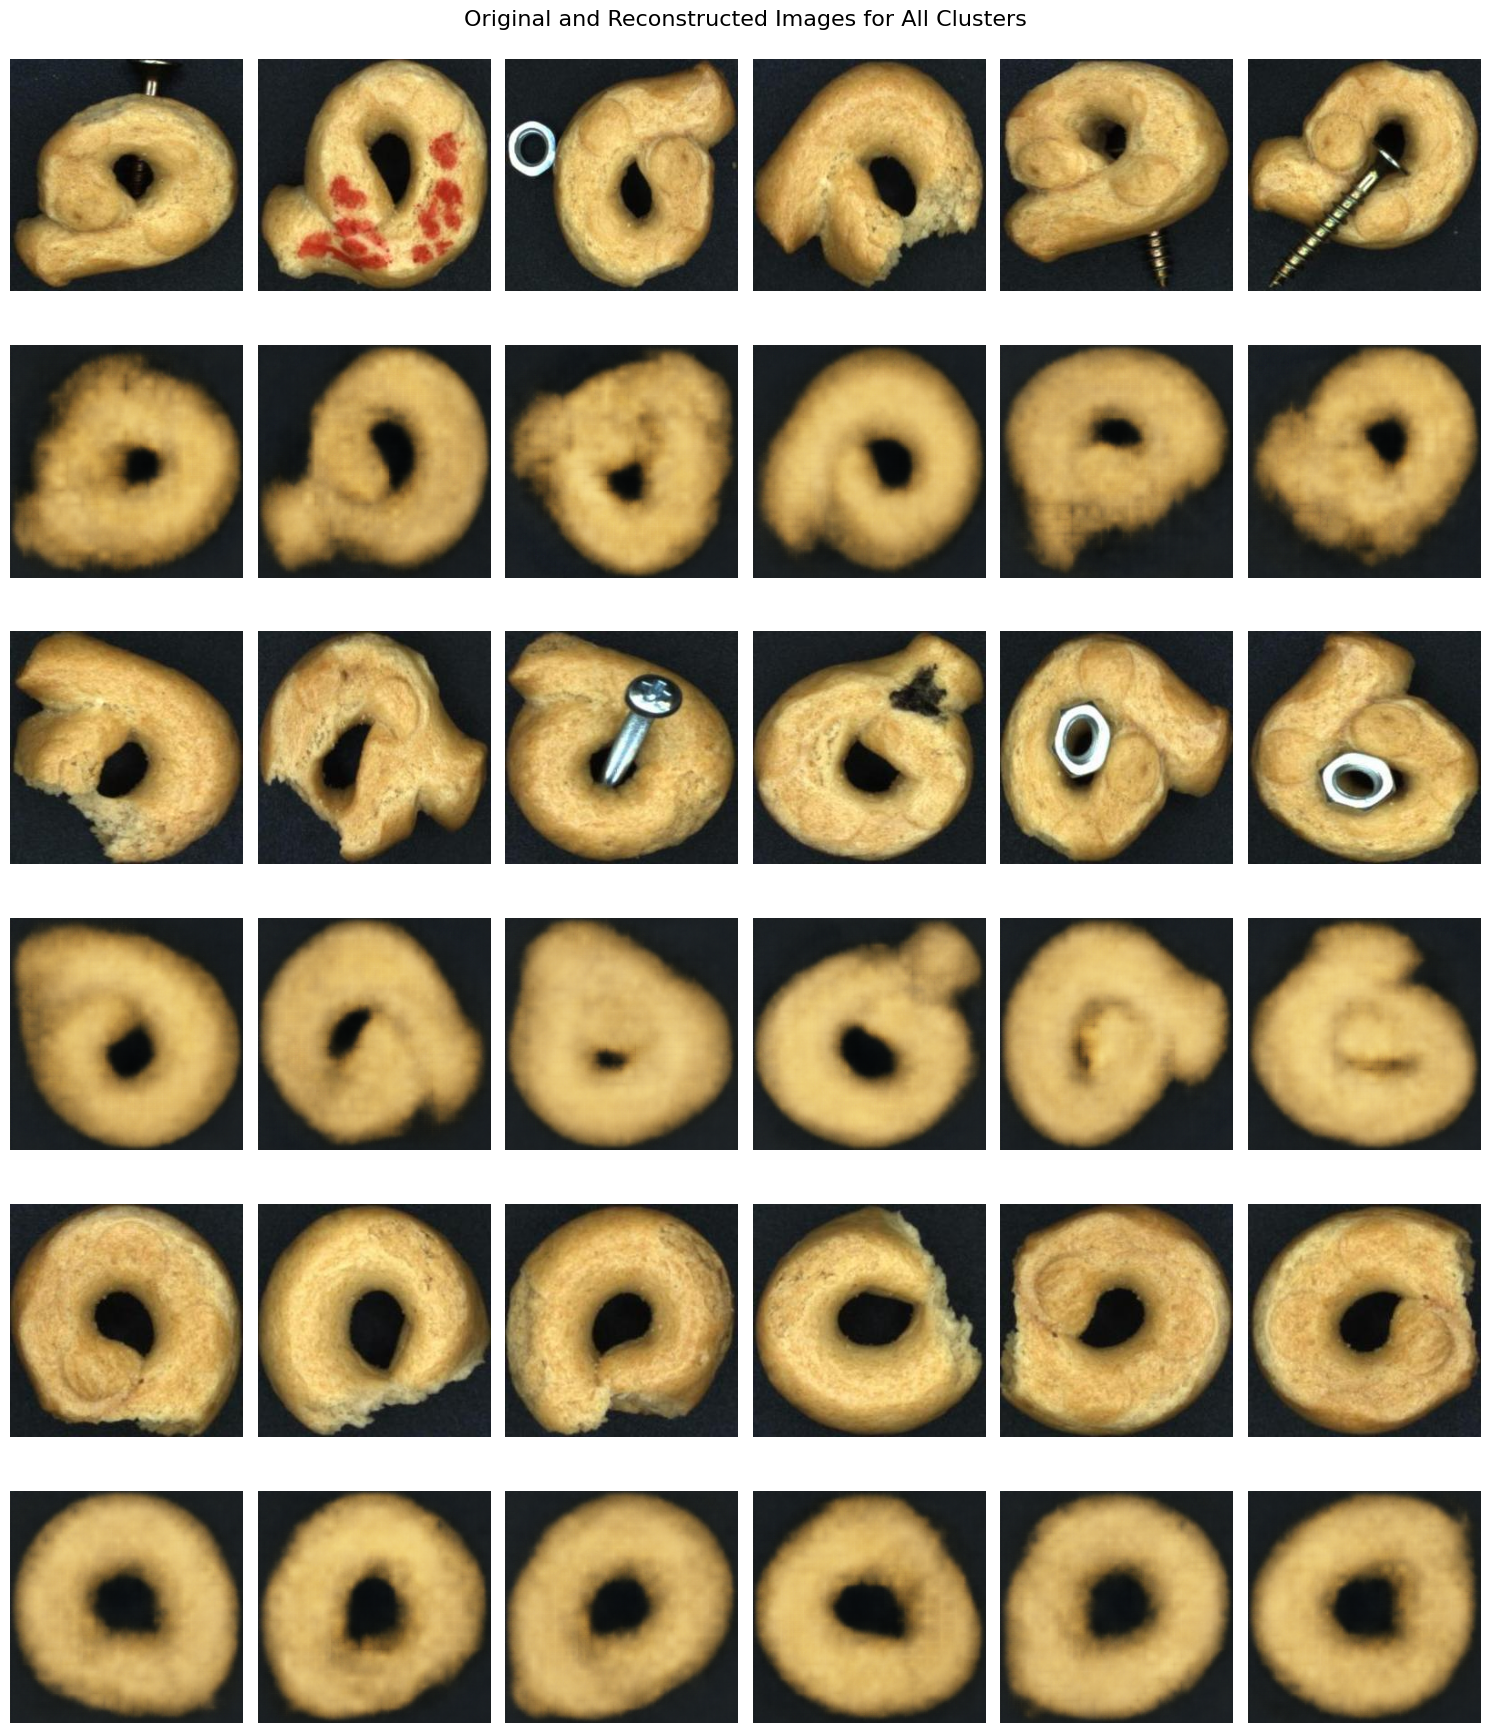

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Step 1: Get only the NOK samples
X_nok = X_test[y_test == 1]

# Step 2: Get latent vectors for NOK images
z_nok = vae.encoder(X_nok)[2].numpy()  # Assuming the encoder outputs latent vectors at index 2

# Step 3: Cluster into 3 groups for 3 defect types
kmeans = KMeans(n_clusters=3, random_state=40)
cluster_labels = kmeans.fit_predict(z_nok)  # Unsupervised cluster assignment

# Step 4: Visualize clusters in latent space using t-SNE
z_2d = TSNE(n_components=2, random_state=42).fit_transform(z_nok)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.title("VAE Latent Space - Clustered NOK Defects")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 5: Visualize original and reconstructed images for each cluster
def visualize_all_clusters(X_test, X_test_reconstructed, y_test, cluster_labels, n=6):
    """
    Visualize original vs reconstructed images for all clusters.

    Parameters:
    - X_test: Original test images (NumPy array).
    - X_test_reconstructed: Reconstructed test images (NumPy array).
    - y_test: Ground truth labels (1 for defective, 0 for non-defective).
    - cluster_labels: Cluster assignments for defective samples.
    - n: Number of images to display per cluster.
    """
    # Get indices of defective samples in the original dataset
    nok_indices = np.where(y_test == 1)[0]

    # Number of clusters
    num_clusters = len(np.unique(cluster_labels))

    # Create a figure for visualization
    plt.figure(figsize=(15, num_clusters * 6))

    for cluster in range(num_clusters):
        # Get indices of samples in the current cluster
        cluster_indices = nok_indices[cluster_labels == cluster]

        # Randomly select n samples from the cluster
        selected_indices = np.random.choice(cluster_indices, n, replace=False)

        for i, idx in enumerate(selected_indices):
            # Retrieve the corresponding original and reconstructed images
            original_image = X_test[idx]
            reconstructed_image = X_test_reconstructed[idx]

            # Plot the original image
            ax_orig = plt.subplot(num_clusters * 2, n, cluster * 2 * n + i + 1)
            ax_orig.imshow(original_image, cmap='gray')  # Adjust `cmap` if images are RGB
            ax_orig.axis('off')
            if i == 0:
                ax_orig.set_ylabel(f"Cluster {cluster}\nOriginal", fontsize=12, labelpad=10)

            # Plot the reconstructed image
            ax_recon = plt.subplot(num_clusters * 2, n, cluster * 2 * n + n + i + 1)
            ax_recon.imshow(reconstructed_image, cmap='gray')  # Adjust `cmap` if images are RGB
            ax_recon.axis('off')
            if i == 0:
                ax_recon.set_ylabel("Reconstruction", fontsize=12, labelpad=10)

    plt.suptitle("Original and Reconstructed Images for All Clusters", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_all_clusters(X_test, X_test_reconstructed, y_test, cluster_labels, n=6)